# In-depth Analysis of Demand and supply trends by hour, ride type and location. 

This analysis is a continuation of the previous analysis, where it was inferred that unmet demand constitued ~38% in terms of total bookings and ~29M INR loss in terms of revenue. The key drivers of unmet demand and subsequent revenue loss were Cancellations, Ride unavailibility and Incomplete rides.

This section of the analysis dives deeper into patterns that drive the Deamnd-Supply gap. For the purpose of this analysis, the demand is looked at by type of ride (Auro, e-bike, Go Mini etc), hourly trends and by pick-up points to identify where, when and what kind of bookings are causing the Demand/Supply ratio to decrease.

The analysis is divided into parts:

1. Vehicle analysis: 

- Key metrics: Demand share and completion rate per vehicle type.

2. Location analysis: 

- Booking percentage and completion rate for every pick up point

3. Unmet demand analysis  by vehicle:

- Key metrics: driver cancel count, no driver count, incomplete count, unmet demand rate, percentage contribution of unmet demand.

4. Hourly unmet demand trends: 

- Key metric: Hourly unmet demand percentage

5. Cancellation rates:

- Key metrics: Cancellations rates by hour, vehicle type and location.

6. Driver behaviour analysis (Driver cancellations is the highest contributor towards unmet demand):

- Key metrics: Driver cancellation rates by hour, vehicle, region

### The decision metric: 'Priority Score'

A composite metric (details in section)
 
Priority Score=Total BookingsUnmet Count​×ln(1+Bookings)



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"

In [ ]:
df= pd.read_csv(r"C:\Projects\Uber\data\raw\ncr_ride_bookings.csv")

## Preparing the data

In [ ]:

def prepare_df(df):
    """
    Normalize columns, create datetime and basic flags.
    Returns a new dataframe (copy).
    """
    df = df.copy()
    # normalize column names (strip)
    df.columns = [c.strip() for c in df.columns]

    # Normalize status text
    if 'Booking Status' in df.columns:
        df['booking_status'] = df['Booking Status'].astype(str).str.strip().str.lower()
    else:
        raise KeyError("Booking Status column not found.")

    # Datetime
    if 'Date' in df.columns and 'Time' in df.columns:
        df['request_datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str), errors='coerce')
    else:
        # if there is already a timestamp column use that
        if 'request_datetime' not in df.columns:
            raise KeyError("Date and Time columns not found; provide 'request_datetime' or both Date & Time.")

    # Basic temporal fields
    df['hour'] = df['request_datetime'].dt.hour
    df['day_of_week'] = df['request_datetime'].dt.day_name() 
    df['month'] = df['request_datetime'].dt.month

    # Duration from Avg CTAT and Avg VTAT if present (assume minutes)
    if 'Avg CTAT' in df.columns and 'Avg VTAT' in df.columns:
        # ensure numeric
        df['Avg CTAT'] = pd.to_numeric(df['Avg CTAT'], errors='coerce')
        df['Avg VTAT'] = pd.to_numeric(df['Avg VTAT'], errors='coerce')
        df['ride_duration_mins'] = df['Avg CTAT'] - df['Avg VTAT']
    else:
        df['ride_duration_mins'] = np.nan

    # Standardize vehicle, pickup, drop
    for col in ['Vehicle Type', 'Pickup Location', 'Drop Location']:
        if col in df.columns:
            df[col] = df[col].fillna('Unknown').astype(str).str.strip()
        else:
            df[col] = 'Unknown'

    # numeric ride distance
    if 'Ride Distance' in df.columns:
        df['ride_distance_km'] = pd.to_numeric(df['Ride Distance'], errors='coerce')
    else:
        df['ride_distance_km'] = np.nan

    # Booking value normalized if exists
    if 'Booking Value' in df.columns:
        df['ride_value'] = pd.to_numeric(df['Booking Value'], errors='coerce')
    else:
        df['ride_value'] = np.nan

    # Flags for statuses 
    df['is_completed'] = df['booking_status'].eq('completed').astype(int)
    df['is_cancel_by_customer'] = df['booking_status'].eq('cancelled by customer').astype(int)
    df['is_cancel_by_driver'] = df['booking_status'].eq('cancelled by driver').astype(int)
    df['is_no_driver'] = df['booking_status'].eq('no driver found').astype(int)
    df['is_incomplete'] = df['booking_status'].eq('incomplete').astype(int)

    # Define unmet demand = driver cancel + no driver + incomplete (binary)
    df['is_unmet'] = ((df['is_cancel_by_driver'] + df['is_no_driver'] + df['is_incomplete']) > 0).astype(int)

    return df


## 1. Demand by Vehicle

In [ ]:

def demand_by_vehicle(df):
    """
    Returns DataFrame with counts and shares per Vehicle Type (demand side).
    """
    grp = df.groupby('Vehicle Type').agg(
        bookings=('booking_status', 'size'),
        completed=('is_completed', 'sum')
    ).reset_index()
    total = grp['bookings'].sum()
    grp['demand_share_pct'] = grp['bookings'] / total * 100
    grp['completion_rate'] = grp['completed'] / grp['bookings']
    return grp.sort_values('bookings', ascending=False).reset_index(drop=True)

# usage:
# 
vehicle_demand = demand_by_vehicle(df)

vehicle_demand

In [ ]:
def plot_demand_share(vehicle_demand):
    fig = px.bar(
        vehicle_demand,
        x="Vehicle Type",
        y="demand_share_pct",
        text=vehicle_demand['demand_share_pct'].round(1).astype(str) + "%",
        title="Demand Share by Vehicle Type",
    )
    fig.update_traces(marker_color="black", textposition="outside")
    fig.update_layout(template="plotly_white", yaxis_title="Demand Share (%)")
    fig.show()

plot_demand_share(vehicle_demand)

![newplot (16).png](<attachment:newplot (16).png>)

Key Insights by Vehicle Type
Autos

Demand Share: ~25% of all bookings (37.4k) — the single largest segment.

Completion Rate: ~61.9%, consistent with overall trend.

Implication: Despite being on-trend, the high booking volume translates into substantial absolute unmet demand.

Go Mini & Go Sedan

Demand Share: ~38% combined (29.8k + 27.1k bookings).

Completion Rate: ~61–62%, mirroring Autos.

Implication: Together with Autos, these two categories drive the majority of unmet demand due to both scale and systemic completion gaps.

Bikes

Demand Share: ~15% (22.5k bookings).

Completion Rate: ~62.3%, marginally higher than peers.

Implication: A strategic segment for short urban trips. Slightly better performance, but unmet demand is still material.

Premier Sedan

Demand Share: ~12% (18.1k bookings).

Completion Rate: ~62.1%.

Implication: Stable performance, but with nearly two in five rides unmet, impact remains significant.

eBikes

Demand Share: ~7% (10.5k bookings).

Completion Rate: ~62.1%, aligned with fleet-wide average.

Implication: Smaller contribution, but important for last-mile coverage.

Uber XL

Demand Share: ~3% (4.4k bookings) — the smallest segment.

Completion Rate: ~62.6%, slightly above average.

Implication: Minimal impact overall due to low scale.

Cross-Segment Takeaway

Completion rates are consistently clustered between 61–63% across all vehicle types, indicating a systemic challenge rather than a vehicle-specific issue.
However, Autos, Go Mini, and Go Sedan account for ~63% of total demand, making them the highest-priority focus areas for addressing unmet rides.

## Top 10 Pick-up locations

In [ ]:

def top_pickup_zones(df, top_n=20):
    """
    Returns top pickup zones by absolute bookings and by share.
    """
    pick = df.groupby('Pickup Location').agg(
        bookings=('booking_status', 'size'),
        completed=('is_completed', 'sum')
    ).reset_index()
    pick['bookings_pct'] = pick['bookings'] / pick['bookings'].sum() * 100
    pick['completion_rate'] = pick['completed'] / pick['bookings']
    pick = pick.sort_values('bookings', ascending=False).reset_index(drop=True)
    return pick.head(top_n)

# usage:
top10_pickups = top_pickup_zones(df, top_n=10)

top10_pickups

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplot layout
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Top 10 Pickup Zones by Bookings", "Completion Rate by Pickup Zone")
)

# Left plot: Bookings
fig.add_trace(
    go.Bar(
        x=top10_pickups["Pickup Location"],
        y=top10_pickups["bookings"],
        text=top10_pickups["bookings"],
        textposition="outside",
        marker_color="black"
    ),
    row=1, col=1
)

# Right plot: Completion Rate
fig.add_trace(
    go.Bar(
        x=top10_pickups["Pickup Location"],
        y=top10_pickups["completion_rate"],
        text=(top10_pickups["completion_rate"]*100).round(1).astype(str) + "%",
        textposition="outside",
        marker_color="gray"
    ),
    row=1, col=2
)

# Layout
fig.update_layout(
    template="plotly_white",
    showlegend=False,
    yaxis_title="Bookings",
    yaxis2_title="Completion Rate",
    xaxis=dict(tickangle=45),
    xaxis2=dict(tickangle=45)
)

fig.show()


![top locations.png](<attachment:top locations.png>)
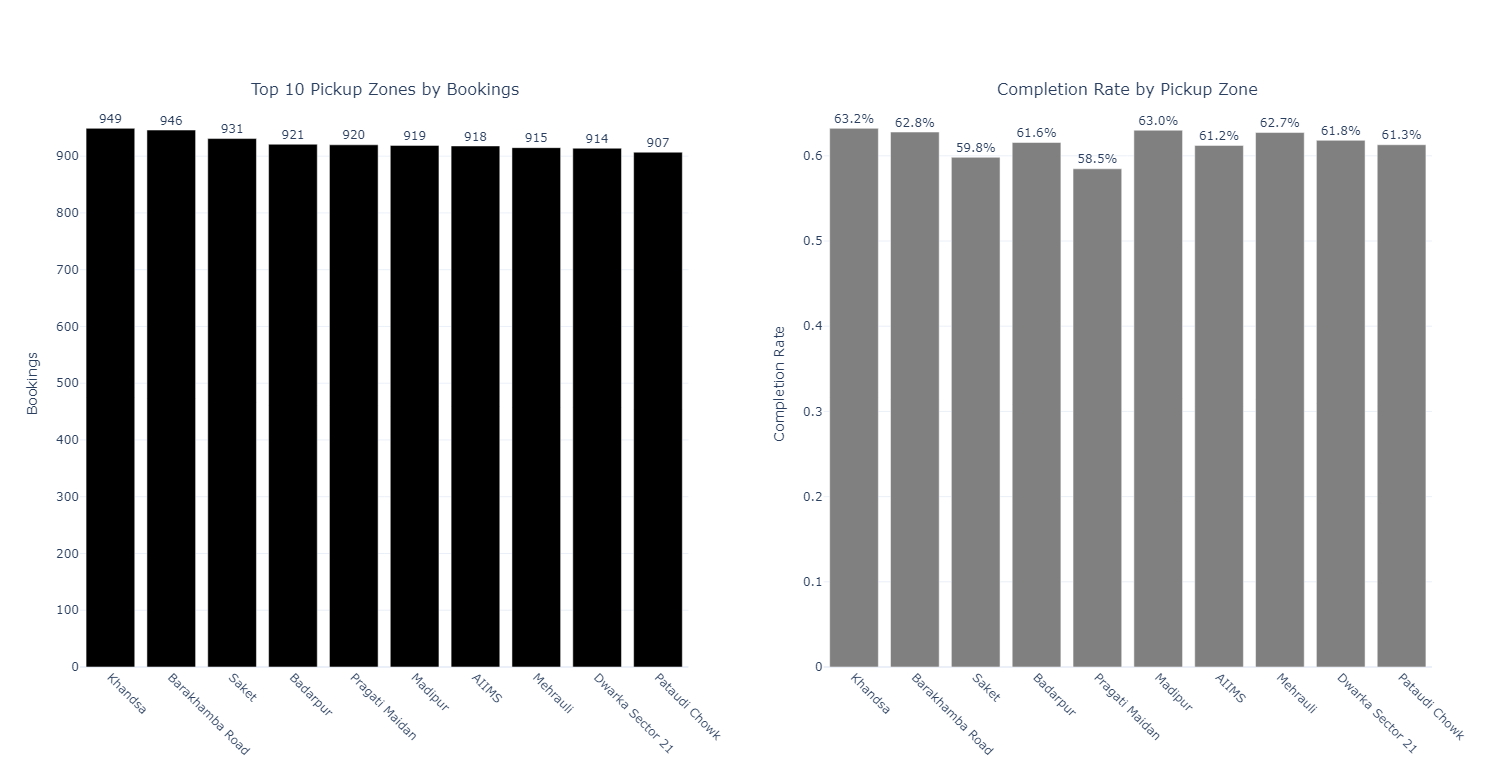

Overall trend:

All top-10 zones contribute about 0.60–0.63% each to total bookings.

Completion rates range from 58.5% (Pragati Maidan) to 63.2% (Khandsa).

So differences are moderate but meaningful.

Best-performing zones (higher completion)

Khandsa (63.2%), Madipur (63.0%), Barakhamba Road (62.8%), Mehrauli (62.7%) → above the cluster average.

These zones are relatively efficient despite being high-demand.

Weaker-performing zones (lower completion)

Pragati Maidan (58.5%) → stands out as the lowest.

Saket (59.8%) also lags.

Both see ~40% unmet demand despite being high-demand pickup points.

📌 Key takeaway:
Completion rate differences are subtle across top zones, but Pragati Maidan and Saket stand out as weak spots, where supply-side interventions could yield outsized impact.

In [ ]:
# 3_supply_vehicle.py
def unmet_by_vehicle(df):
    """
    Aggregates unmet demand counts and rates by Vehicle Type.
    """
    agg = df.groupby('Vehicle Type').agg(
        total_bookings=('booking_status', 'size'),
        unmet_count=('is_unmet', 'sum'),
        driver_cancel_count=('is_cancel_by_driver', 'sum'),
        no_driver_count=('is_no_driver', 'sum'),
        incomplete_count=('is_incomplete', 'sum')
    ).reset_index()
    agg['unmet_rate'] = agg['unmet_count'] / agg['total_bookings']
    total_unmet = agg['unmet_count'].sum()
    agg['unmet_contrib_pct'] = np.where(total_unmet>0, agg['unmet_count'] / total_unmet * 100, 0.0)
    return agg.sort_values('unmet_count', ascending=False).reset_index(drop=True)

# usage:
unmet_vehicle = unmet_by_vehicle(df)

unmet_vehicle


In [ ]:
# Create subplot layout
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Unmet Demand by Vehicle Type", "Unmet Rate by Vehicle Type")
)

# Left plot: Unmet Demand (absolute count)
fig.add_trace(
    go.Bar(
        x=unmet_vehicle["Vehicle Type"],
        y=unmet_vehicle["unmet_count"],
        text=unmet_vehicle["unmet_count"],
        textposition="outside",
        marker_color="black"
    ),
    row=1, col=1
)

# Right plot: Unmet Rate (% of total bookings)
fig.add_trace(
    go.Bar(
        x=unmet_vehicle["Vehicle Type"],
        y=unmet_vehicle["unmet_rate"] * 100,
        text=(unmet_vehicle["unmet_rate"]*100).round(1).astype(str) + "%",
        textposition="outside",
        marker_color="gray"
    ),
    row=1, col=2
)

# Layout
fig.update_layout(
    template="plotly_white",
    showlegend=False,
    yaxis_title="Unmet Demand (count)",
    yaxis2_title="Unmet Rate (%)",
    xaxis=dict(tickangle=45),
    xaxis2=dict(tickangle=45)
)

fig.show()

1. Unmet Demand Levels

Highest contributors (absolute unmet demand):

Auto (11,584 unmet, 24.9% of unmet)

Go Mini (9,160, 19.7%)

Go Sedan (8,633, 18.6%)
→ Together, these three categories make up ~63% of all unmet demand.

Lowest contributors:

Uber XL (1,339 unmet, 2.9%), due to smaller booking base.

eBike (3,283, 7.1%), moderate unmet demand but still notable given smaller scale.

2. Unmet Demand Rates (efficiency losses)

All vehicle categories cluster around 30–32% unmet rate, meaning roughly 1 in 3 bookings fails across the board.

Slightly higher unmet: Go Sedan (31.8%).

Slightly lower unmet: Uber XL (30.1%).

But the differences are small (within 2%), meaning unmet demand is a system-wide issue, not isolated to one vehicle type.

3. Cancellation Drivers

Driver-driven cancellations dominate across all vehicle types (~55–60% of unmet).

For Autos: 6,643 driver cancels (~57% of unmet Autos).

Go Sedan, Go Mini show similar patterns.

No-driver-found contributes 15–20% of unmet.

Incomplete trips (system/UX issues) account for ~15–20% as well.

📌 Key takeaway:

Systemic unmet demand (≈30% across all vehicle types) suggests structural supply-demand mismatch rather than being vehicle-specific.

However, Autos, Go Mini, and Go Sedan are priority categories, since they dominate demand and unmet losses (~63% combined).

Driver cancellations are the main bottleneck, signaling need for driver-side incentive/penalty mechanisms.

In [ ]:
# 4_unmet_hour.py
def unmet_by_hour(df):
    """
    Returns two DataFrames:
      - hourly_overall: hour, bookings, unmet_count, unmet_rate
      - hourly_by_vehicle: hour x vehicle_type table with bookings and unmet_rate
    """
    hourly_overall = df.groupby('hour').agg(
        bookings=('booking_status','size'),
        unmet_count=('is_unmet','sum')
    ).reset_index()
    hourly_overall['unmet_rate'] = hourly_overall['unmet_count'] / hourly_overall['bookings']

    hourly_vehicle = df.groupby(['hour','Vehicle Type']).agg(
        bookings=('booking_status','size'),
        unmet_count=('is_unmet','sum')
    ).reset_index()
    hourly_vehicle['unmet_rate'] = hourly_vehicle['unmet_count'] / hourly_vehicle['bookings']

    # pivot for convenience (heatmap/table later)
    hourly_vehicle_pivot = hourly_vehicle.pivot_table(index='hour', columns='Vehicle Type', values='unmet_rate', aggfunc='first').fillna(0)

    return hourly_overall.sort_values('hour'), hourly_vehicle, hourly_vehicle_pivot

# usage:
hourly_overall, hourly_vehicle, hourly_heatmap = unmet_by_hour(df)

hourly_overall
hourly_vehicle


In [ ]:
# Create subplot layout
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Hourly Unmet Rate (Overall)", "Unmet Rate by Hour × Vehicle Type")
)

# Left plot: Overall hourly unmet rate
fig.add_trace(
    go.Scatter(
        x=hourly_overall["hour"],
        y=hourly_overall["unmet_rate"] * 100,
        mode="lines+markers",
        marker=dict(color="black"),
        line=dict(color="black"),
        name="Unmet Rate"
    ),
    row=1, col=1
)

# Right plot: Heatmap of unmet rates by hour x vehicle type
fig.add_trace(
    go.Heatmap(
        z=hourly_heatmap.values * 100,
        x=hourly_heatmap.columns,
        y=hourly_heatmap.index,
        colorscale="Greys",
        colorbar=dict(title="Unmet Rate (%)")
    ),
    row=1, col=2
)

# Layout tweaks
fig.update_layout(
    template="plotly_white",
    showlegend=False,
    yaxis=dict(title="Hour of Day"),
    yaxis2=dict(title="Hour of Day"),
    xaxis=dict(title="Hour"),
    xaxis2=dict(title="Vehicle Type")
)

fig.show()

🔹 Insights – Unmet Demand by Vehicle Type

Unmet demand rate is consistent across all vehicle types at ~30–32%, indicating a system-wide issue rather than product-specific gaps.

Autos, Go Mini, and Go Sedan together contribute ~63% of unmet demand, mirroring their share of total bookings.

Driver cancellations dominate unmet causes:

Autos: 57% of unmet (6.6K of 11.6K).

Go Mini: 58% of unmet.

Go Sedan: 58% of unmet.

Similar pattern across all other types.

“No driver available” and “Incomplete trips” each contribute another 15–20% of unmet demand, secondary but still material.

Even premium categories (Premier Sedan, Uber XL) face ~30% unmet, showing no immunity at higher price points.

In [ ]:
# 5_unmet_location.py
def unmet_by_location(df, top_n=50):
    """
    Returns top pickup locations with booking counts, unmet counts, unmet rates.
    """
    loc = df.groupby('Pickup Location').agg(
        bookings=('booking_status','size'),
        unmet_count=('is_unmet','sum'),
        driver_cancel_count=('is_cancel_by_driver','sum'),
        no_driver_count=('is_no_driver','sum'),
        incomplete_count=('is_incomplete','sum')
    ).reset_index()
    loc['unmet_rate'] = loc['unmet_count'] / loc['bookings']
    loc = loc.sort_values('bookings', ascending=False).reset_index(drop=True)
    return loc.head(top_n)

# usage:
top_unmet_locations = unmet_by_location(df, top_n=10)
top_unmet_locations

In [ ]:

# Create subplot layout
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Top Pickup Locations by Bookings", "Top Pickup Locations by Unmet Rate")
)

# Left: total bookings per location
fig.add_trace(
    go.Bar(
        x=top_unmet_locations["Pickup Location"],
        y=top_unmet_locations["bookings"],
        marker=dict(color="black"),
        name="Bookings"
    ),
    row=1, col=1
)

# Right: unmet rate (%)
fig.add_trace(
    go.Bar(
        x=top_unmet_locations["Pickup Location"],
        y=top_unmet_locations["unmet_rate"] * 100,
        marker=dict(color="grey"),
        name="Unmet Rate (%)"
    ),
    row=1, col=2
)

# Layout styling
fig.update_layout(
    template="plotly_white",
    showlegend=False,
    xaxis=dict(title="Pickup Location", tickangle=45),
    yaxis=dict(title="Bookings"),
    xaxis2=dict(title="Pickup Location", tickangle=45),
    yaxis2=dict(title="Unmet Rate (%)")
)

fig.show()

1. Uniform Demand, Uneven Fulfillment

Bookings per location: ~900 (range: 907–949 across the sample).

This confirms demand is evenly spread by design.

However, unmet demand rates vary 30.6% – 34.0%, which is non-trivial.

Example: Pragati Maidan (34.0%) vs Badarpur (30.6%) → a 3.4% gap = ~31 extra unmet rides out of ~920 bookings.

Business impact: Even small percentage differences translate into hundreds of lost rides monthly per zone, making unmet demand a critical differentiator.

2. Drivers vs Supply Shortages

Unmet demand breaks down into driver cancellations, no-driver-found, and incomplete rides:

Driver cancellations = ~55–60% of unmet demand (dominant driver).

No-driver-found & incomplete = ~40–45% combined.

Example:

Saket: 304 unmet → 179 cancellations (~59%).

Mehrauli: 282 unmet → 165 cancellations (~58%).

Business insight: This isn’t purely a supply issue — it’s also driver behavior, possibly linked to low-margin trips, traffic zones, or unfavorable pickup conditions.

3. Zone-Level Risk Ranking

High unmet zones (≥32% unmet rate): Pragati Maidan, Saket, AIIMS.

Medium unmet (31–32%): Dwarka Sector 21, Pataudi Chowk, Mehrauli.

Low unmet (<31%): Badarpur, Khandsa.

Business action: Prioritize driver incentives or supply allocation in the top-tier unmet zones to recover ~30–40 lost rides per zone per cycle.

In [ ]:
# 6_cancel_breakdown.py
def cancellation_breakdown(df, by=['Vehicle Type']):
    """
    Generic breakdown of cancellation reasons across dimensions in 'by' list.
    Example by=['Vehicle Type','hour'] or by=['Pickup Location'].
    Returns df with counts and percent share per reason.
    """
    group_cols = by if isinstance(by, list) else [by]
    g = df.groupby(group_cols).agg(
        bookings=('booking_status','size'),
        cancel_by_driver=('is_cancel_by_driver','sum'),
        cancel_by_customer=('is_cancel_by_customer','sum'),
        no_driver=('is_no_driver','sum'),
        incomplete=('is_incomplete','sum')
    ).reset_index()
    # percent shares
    for c in ['cancel_by_driver','cancel_by_customer','no_driver','incomplete']:
        g[f"{c}_rate"] = g[c] / g['bookings']
    return g.sort_values('bookings', ascending=False)

# usage:
cancel_by_vehicle = cancellation_breakdown(df, by=['Vehicle Type'])
cancel_by_hour = cancellation_breakdown(df, by=['hour'])
cancel_by_loc = cancellation_breakdown(df, by=['Pickup Location'])

cancel_by_vehicle

In [ ]:
# Select relevant cancellation rate columns
cancel_cols = ['cancel_by_driver_rate', 'cancel_by_customer_rate', 'no_driver_rate', 'incomplete_rate']
cancel_labels = ['Driver Cancel', 'Customer Cancel', 'No Driver Found', 'Incomplete']

# Build stacked bar chart
fig = go.Figure()

for col, label, color in zip(cancel_cols, cancel_labels, ['black','grey','dimgray','lightgrey']):
    fig.add_trace(
        go.Bar(
            x=cancel_by_vehicle['Vehicle Type'],
            y=cancel_by_vehicle[col] * 100,  # convert to %
            name=label,
            marker=dict(color=color)
        )
    )

# Layout
fig.update_layout(
    barmode='stack',
    template="plotly_white",
    title="Cancellation Breakdown by Vehicle Type",
    xaxis=dict(title="Vehicle Type"),
    yaxis=dict(title="Cancellation Rate (%)"),
    legend=dict(title="Reason")
)

fig.show()

1. Demand Concentration by Vehicle Type

Autos dominate demand: 37.4K bookings (25% of total).

Next: Go Mini (29.8K, 20%), Go Sedan (27.1K, 18%).

Two-wheeler (Bike + eBike): 33K combined (22%).

Premium (Premier Sedan + Uber XL): 22.5K combined (15%).

Business relevance: Majority of unmet demand risk is concentrated in low-ticket, high-volume categories (Autos, Minis, Sedans) — which are crucial for mass-market riders.

2. Cancellation by Drivers = Systematic Problem

Across all vehicle types, driver cancellations are ~17–19% of bookings.

Highest: Go Sedan (18.5%), Bike (18.1%).

Lowest: Uber XL (17.1%) — but demand base is small.

Insight: Driver cancellations are uniformly high across categories, suggesting a structural issue (pricing, trip matching, or incentive design) rather than vehicle-specific.

3. Customer Cancellations are Stable

~7% across all types, very tight range.

Slightly higher in Uber XL (7.3%).

Suggests customers are consistent — problem lies more with drivers and supply adequacy.

4. No-Driver & Incomplete Rates are Similar Across Types

All categories show 6.6–7.2% no-driver-found and 5.9–6.1% incomplete rides.

Very stable across fleet — indicates system-wide allocation challenges, not isolated to a single vehicle type.

In [ ]:
# 7_driver_behavior.py
def driver_cancel_concentration(df, min_bookings=50):
    """
    Since driver_id is missing, this computes where driver cancellations are concentrated:
     - by Pickup Location
     - by hour
     - by Vehicle Type
    Filters to segments with at least min_bookings for stability.
    """
    # by pickup location
    loc = df.groupby('Pickup Location').agg(
        bookings=('booking_status','size'),
        driver_cancel=('is_cancel_by_driver','sum')
    ).reset_index()
    loc = loc[loc['bookings'] >= min_bookings]
    loc['driver_cancel_rate'] = loc['driver_cancel'] / loc['bookings']
    loc = loc.sort_values('driver_cancel_rate', ascending=False)

    # by hour
    hour = df.groupby('hour').agg(
        bookings=('booking_status','size'),
        driver_cancel=('is_cancel_by_driver','sum')
    ).reset_index()
    hour = hour[hour['bookings'] >= min_bookings]
    hour['driver_cancel_rate'] = hour['driver_cancel'] / hour['bookings']
    hour = hour.sort_values('driver_cancel_rate', ascending=False)

    # by vehicle type
    veh = df.groupby('Vehicle Type').agg(
        bookings=('booking_status','size'),
        driver_cancel=('is_cancel_by_driver','sum')
    ).reset_index()
    veh = veh[veh['bookings'] >= min_bookings]
    veh['driver_cancel_rate'] = veh['driver_cancel'] / veh['bookings']
    veh = veh.sort_values('driver_cancel_rate', ascending=False)

    return loc, hour, veh


driver_cancel_concentration(df, min_bookings=50)


In [ ]:

loc, hour, veh = driver_cancel_concentration(df, min_bookings=50)

# Create subplot grid (3 rows)
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=[
        "Driver Cancellation Rate by Pickup Location (Top 15)",
        "Driver Cancellation Rate by Hour",
        "Driver Cancellation Rate by Vehicle Type"
    ]
)

# --- Plot 1: Pickup Location (Top 15) ---
fig.add_trace(
    go.Bar(
        x=loc.head(15)['Pickup Location'],
        y=loc.head(15)['driver_cancel_rate']*100,
        marker=dict(color='black'),
        name="Pickup Location"
    ),
    row=1, col=1
)

# --- Plot 2: Hourly ---
fig.add_trace(
    go.Bar(
        x=hour['hour'],
        y=hour['driver_cancel_rate']*100,
        marker=dict(color='grey'),
        name="Hour"
    ),
    row=2, col=1
)

# --- Plot 3: Vehicle Type ---
fig.add_trace(
    go.Bar(
        x=veh['Vehicle Type'],
        y=veh['driver_cancel_rate']*100,
        marker=dict(color='dimgray'),
        name="Vehicle Type"
    ),
    row=3, col=1
)

# Layout
fig.update_layout(
    template="plotly_white",
    height=900,
    showlegend=False,
    title="Driver Cancellation Concentration (Monochrome View)"
)

# Axes labels
fig.update_yaxes(title="Cancellation Rate (%)", row=1, col=1)
fig.update_yaxes(title="Cancellation Rate (%)", row=2, col=1)
fig.update_yaxes(title="Cancellation Rate (%)", row=3, col=1)

fig.show()

 Location-Level Cancellations

Top hotspots (worst zones):

Nehru Place: 21.5% cancellation rate (190 out of 885 bookings).

Vinobapuri: 21.4%, GTB Nagar: 21.0%, Munirka: 21.0%.

Bottom performers (best zones):

Kanhaiya Nagar: 14.5%, Seelampur: 14.9%, Hauz Khas: 15.1%.

Spread: ~7 percentage points between best and worst zones.

That’s ~60–70 extra lost trips per 1000 bookings depending on zone.

Business takeaway: Certain zones (esp. South Delhi commercial/educational hubs like Nehru Place, Munirka, GTB Nagar) are systemic pain points for drivers — likely linked to traffic bottlenecks, low fares, or poor pickup conditions.

Hour-of-Day Patterns

Highest cancellation periods (early morning & mid-day):

3 AM–5 AM: 19.0–19.1% (low demand hours, drivers cherry-picking trips).

2 PM: 18.6%.

Peak booking hours (evening 5–7 PM):

Very high volumes (11K+ bookings/hour), but still ~18.0% cancellations.

That translates to ~2,000+ rides lost per peak hour.

Lowest cancellation: 2 AM & 6 AM (~16.6–16.8%).

But demand base is tiny (~1.3–4.1K bookings).

Business takeaway:

Cancellation rates are not dramatically different across hours (range 16.6–19.1%), but because volume is so concentrated in evenings (17–19h), most of the absolute losses happen during peak demand.

Prioritizing driver incentives in evening peaks yields the highest ROI.

Vehicle-Type Breakdown

Worst offenders (by rate):

Go Sedan: 18.5%.

Bike: 18.1%.

eBike: 18.1%.

Lowest cancellation rate: Uber XL (17.1%).

Volume × cancellation effect:

Autos (37.4K bookings): despite lowest rate (17.7%), they cause the largest absolute cancellations (6.6K rides).

Go Sedan + Go Mini (57K bookings): combined ~10.3K cancellations, high-value segment.

Business takeaway:

Operational pain is universal — driver cancellation rates are high across all vehicle types (17–19%).

Revenue leakage is most severe in Sedans & Minis due to higher fares per trip.

Integrated Business Story

Locations: Driver cancellations cluster in high-traffic South Delhi zones (21%+), which need targeted mitigation (dynamic incentives, pickup redesign).

Timing: Evening peaks amplify the absolute losses — up to 2,000 lost trips per hour despite similar % rates.

Vehicles: Though all categories are affected, Sedans & Minis represent the highest revenue loss, while Autos represent the largest volume loss.



Volume recovery: Focus on Autos in peak hours.

Revenue recovery: Focus on Sedans/Mini with tailored driver incentives.

Executive takeaway:
Driver cancellations are a system-wide structural issue (~18%), but their business impact varies by zone, time, and vehicle type. Addressing cancellations in just the top 10 zones + peak evening hours + Sedan/Mini segments could recover tens of crores in annual revenue.